# Verifying pyfssa

The *pyfssa* package implements algorithmic finite-size scaling analysis.
In order to verify the autoscaling algorithm, the following computations aim at reproducing the scaling exponents from the literature of the paradigmatic bond percolation problem on a linear chain and on a square lattice.
First, finite-size percolation studies utilizing the *pypercolate* package generate the finite-size data.
Next, we plot these raw data for the percolation probability, the order parameter (largest component) and the susceptibility (second moment of the cluster-size distribution).
For each of these quantities, we scale the simulation data according to the literature exponents and observe the data collapse onto the master curve.
Finally, for each of these quantities, *pyfssa* auto-scales the simulation data in order to recover the literature exponents.

## Percolation simulation design

We utilize the [pypercolate](http://pypercolate.readthedocs.org/en/stable/) package to generate the percolation finite-size data, according to the [template for a HPC bond percolation finite-size scaling study](http://pypercolate.readthedocs.org/en/stable/pypercolate-hpc.html#template-for-a-hpc-bond-percolation-finite-size-scaling-study).
To carry out the simulations in a GridEngine powered high-performance computing environment, we employ the [jug](http://luispedro.org/software/jug/) and [gridjug](http://gridjug.readthedocs.org/en/stable/) packages.
The *jugfiles* contain the control flow for both studies on the [linear chain](_static/bond_percolation_1d_jugfile.py) and the [square lattice](_static/bond_percolation_jugfile.py).
The finite system sizes of the linear chain (number of nodes) are $2^6, 2^8, \ldots, 2^{20}$, and the linear extensions $L_i$ of the $L_i \times L_i$ square lattices (number of nodes) are $2^3, 2^4, \ldots, 2^{10}$.
The total number of runs is $N_{runs} = 10^4$, respectively.
The occupation probabilities are $\{1 - 10^{-(1 + i/10)} : i = 0, \ldots, 100\}$ for the linear chain and $\{0.5 + \frac{i}{500} : i = -50, \ldots, +50\}$ for the square lattice.
The confidence level is at the $1 \sigma$ level, hence $1 - \alpha = \text{erf}\frac{1}{\sqrt{2}} \approx 0.683$.
The master seeds that initialize the Mersenne-Twister RNG to draw the seeds for each run are $3138595788$ for the linear chain and $3939666632$ for the square lattice.

## Preamble

In [1]:
from __future__ import division

In [2]:
# configure plotting
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (3, 3 / 1.6), 'font.size': 10, \
                            'figure.facecolor': (1, 1, 1, 0)}
%matplotlib inline

In [3]:
from pprint import pprint as print
from collections import OrderedDict
import warnings

import h5py
import matplotlib as mpl
import numpy as np
import os
import scipy.stats
import seaborn as sns

import matplotlib.pyplot as plt

from cycler import cycler

import fssa

/home/sorge/repos/sci/pyfssa/.devenv35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Loading and inspecting the raw data

In [4]:
bond_percolation_data = OrderedDict()
bond_percolation_data['1D'] = h5py.File(
    os.path.join('_static', 'bond-percolation-hpc-chain-canonical-averages.hdf5')
)
bond_percolation_data['2D'] = h5py.File(
    os.path.join('_static', 'bond-percolation-hpc-grid-canonical-averages.hdf5')
)

In [5]:
system_sizes = OrderedDict()
for key, data in bond_percolation_data.items():
    system_sizes[key] = sorted([int(group_key) for group_key in data.keys()])
print(system_sizes)

OrderedDict([('1D', [64, 256, 1024, 4096, 16384, 65536, 262144, 1048576]),
             ('2D', [8, 16, 32, 64, 128, 256, 512, 1024])])


In [6]:
print(bond_percolation_data['1D'][str(system_sizes['1D'][0])].dtype.descr)

[('number_of_runs', '<u4'),
 ('p', '<f8'),
 ('alpha', '<f8'),
 ('percolation_probability_mean', '<f8'),
 ('percolation_probability_std', '<f8'),
 ('percolation_probability_ci', '<f8', (2,)),
 ('percolation_strength_mean', '<f8'),
 ('percolation_strength_std', '<f8'),
 ('percolation_strength_ci', '<f8', (2,)),
 ('moments_mean', '<f8', (5,)),
 ('moments_std', '<f8', (5,)),
 ('moments_ci', '<f8', (5, 2))]


In [7]:
def ci_to_std(a, ci):
    return np.max(
        np.abs(
            np.transpose(ci)
            - np.tile(a, (2, 1))
        ),
        axis=0
    )

In [8]:
ps = dict()
n = dict()
alpha = dict()
for key, my_system_sizes in system_sizes.items():
    ps[key] = bond_percolation_data[key][str(my_system_sizes[0])]['p']
    n[key] = bond_percolation_data[key][str(my_system_sizes[0])]['number_of_runs']
    alpha[key] = bond_percolation_data[key][str(my_system_sizes[0])]['alpha']
    assert np.all(n[key] == n[key][0])
    assert np.all(alpha[key] == alpha[key][0])
    for system_size in my_system_sizes:
        assert np.all(bond_percolation_data[key][str(system_size)]['p'] == ps[key])
        assert np.all(bond_percolation_data[key][str(system_size)]['number_of_runs'] == n[key])
        assert np.all(bond_percolation_data[key][str(system_size)]['alpha'] == alpha[key])
    print((key, ps[key], n[key][0], alpha[key][0]))

('1D',
 array([ 0.9       ,  0.91087491,  0.92056718,  0.92920542,  0.93690427,
        0.94376587,  0.94988128,  0.95533164,  0.96018928,  0.96451866,
        0.96837722,  0.97181617,  0.97488114,  0.97761279,  0.98004738,
        0.98221721,  0.98415107,  0.98587462,  0.98741075,  0.98877982,
        0.99      ,  0.99108749,  0.99205672,  0.99292054,  0.99369043,
        0.99437659,  0.99498813,  0.99553316,  0.99601893,  0.99645187,
        0.99683772,  0.99718162,  0.99748811,  0.99776128,  0.99800474,
        0.99822172,  0.99841511,  0.99858746,  0.99874107,  0.99887798,
        0.999     ,  0.99910875,  0.99920567,  0.99929205,  0.99936904,
        0.99943766,  0.99949881,  0.99955332,  0.99960189,  0.99964519,
        0.99968377,  0.99971816,  0.99974881,  0.99977613,  0.99980047,
        0.99982217,  0.99984151,  0.99985875,  0.99987411,  0.9998878 ,
        0.9999    ,  0.99991087,  0.99992057,  0.99992921,  0.9999369 ,
        0.99994377,  0.99994988,  0.99995533,  0.9999601

## Scaling and visualization routines

In [9]:
def autoscale(system_sizes, ps, a, da, rho_c, nu, zeta):
    
    # optimize scaling quality;
    # initialize with exponents from literature
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        res = fssa.autoscale(
            l=system_sizes,
            rho=ps,
            a=a,
            da=da,
            rho_c0=rho_c,
            nu0=nu,
            zeta0=zeta,
        )
    
    if not res['success']:
        raise RuntimeError
    
    return {
        res_key: res[res_key]
        for res_key in [
            'rho', 'drho', 'nu', 'dnu', 'zeta', 'dzeta'
        ]
    }

## Visualizing the raw data and the algorithmic scaling

### Configuration

In [10]:
config = {
    '1D': {
        # 'percolation_probability': {
        #     'slice': np.s_[:],
        #     'exponents': {
        #         'rho_c': 1.0,
        #         'nu': 1.0,
        #         'zeta': 0.0,
        #     },
        # },
        'quantities': [
            'percolation_strength', 'moments',
        ],
        'percolation_strength': {
            'autoscale_slice': np.s_[4:],
            'slice': np.s_[:],
            'exponents': {
                'rho_c': 1.0,
                'nu': 1.0,
                'zeta': 0.0,
            },
        },
        'moments': {
            'autoscale_slice': np.s_[4:],
            'slice': np.s_[:, 2],
            'exponents': {
                'rho_c': 1.0,
                'nu': 1.0,
                'zeta': 1.0,
            },
            'log_data': True,
        },
    },
    '2D': {
        # 'percolation_probability': {
        #     'slice': np.s_[:],
        #     'exponents': {
        #         'rho_c': 0.5,
        #         'nu': 1.333,
        #         'zeta': 0.0,
        #     },            
        # }, 
        'quantities': [
            'percolation_strength', 'moments',
        ],        
        'percolation_strength': {
            'autoscale_slice': np.s_[4:],
            'slice': np.s_[:],
            'exponents': {
                'rho_c': 0.5,
                'nu': 1.333,
                'zeta': -0.133,
            },
        },
        'moments': {
            'autoscale_slice': np.s_[4:],
            'slice': np.s_[:, 2],
            'exponents': {
                'rho_c': 0.5,
                'nu': 1.333,
                'zeta': 2.4,
            },
        },        
    },
    # 'percolation_probability': {
    #     'ylabel': '$P$',            
    # },
    'percolation_strength': {
        'ylabel': '$C_1/N$',            
    },    
    'moments': {
        'ylabel': '$\chi$',
    }
}

### Preparing the data

In [11]:
a = dict()
da = dict()
all_exponents = dict()

for key, my_system_sizes in system_sizes.items():
    a[key] = dict()
    da[key] = dict()
    all_exponents[key] = dict()
    
    for quantity in config[key]['quantities']:
        my_config = config[key][quantity]
        all_exponents[key][quantity] = dict()
        my_slice = my_config['slice']
        exponents = my_config['exponents']
        all_exponents[key][quantity]['literature'] = exponents
        mean_field = '{}_mean'.format(quantity)
        ci_field = '{}_ci'.format(quantity)
        
        a[key][quantity] = np.empty((len(my_system_sizes), ps[key].size))
        da[key][quantity] = np.empty((len(my_system_sizes), ps[key].size))

        for i, system_size in enumerate(my_system_sizes):
            ds = bond_percolation_data[key][str(system_size)]
            a[key][quantity][i] = ds[mean_field][my_slice]
            da[key][quantity][i] = ci_to_std(a[key][quantity][i], ds[ci_field][my_slice])

### Auto-scaling the data

In [12]:
for key, my_system_sizes in system_sizes.items():  # '1D', '2D'
    for quantity in config[key]['quantities']:
        my_config = config[key][quantity]
        my_slice = my_config['autoscale_slice']
        all_exponents[key][quantity]['autoscaled'] = autoscale(
            system_sizes=my_system_sizes[my_slice],
            ps=ps[key],
            a=a[key][quantity][my_slice],
            da=da[key][quantity][my_slice],
            **my_config['exponents']
        )

In [13]:
# scale data with literature and optimized exponents
scaled_data = dict()
for key, my_system_sizes in system_sizes.items():  # '1D', '2D'
    scaled_data[key] = dict()
    for quantity in config[key]['quantities']:
        my_config = config[key][quantity]
        scaled_data[key][quantity] = dict()
        
        opt_exponents = {
            'rho_c': all_exponents[key][quantity]['autoscaled']['rho'],
            'nu': all_exponents[key][quantity]['autoscaled']['nu'],
            'zeta': all_exponents[key][quantity]['autoscaled']['zeta'],            
        }
        for exp_key, exponents in zip(
            ['literature', 'optimized'],
            [my_config['exponents'], opt_exponents]
        ):
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')

                scaled_data[key][quantity][exp_key] = fssa.scaledata(
                    l=my_system_sizes,
                    rho=ps[key],
                    a=a[key][quantity],
                    da=da[key][quantity],
                    **exponents
                )

### Plotting

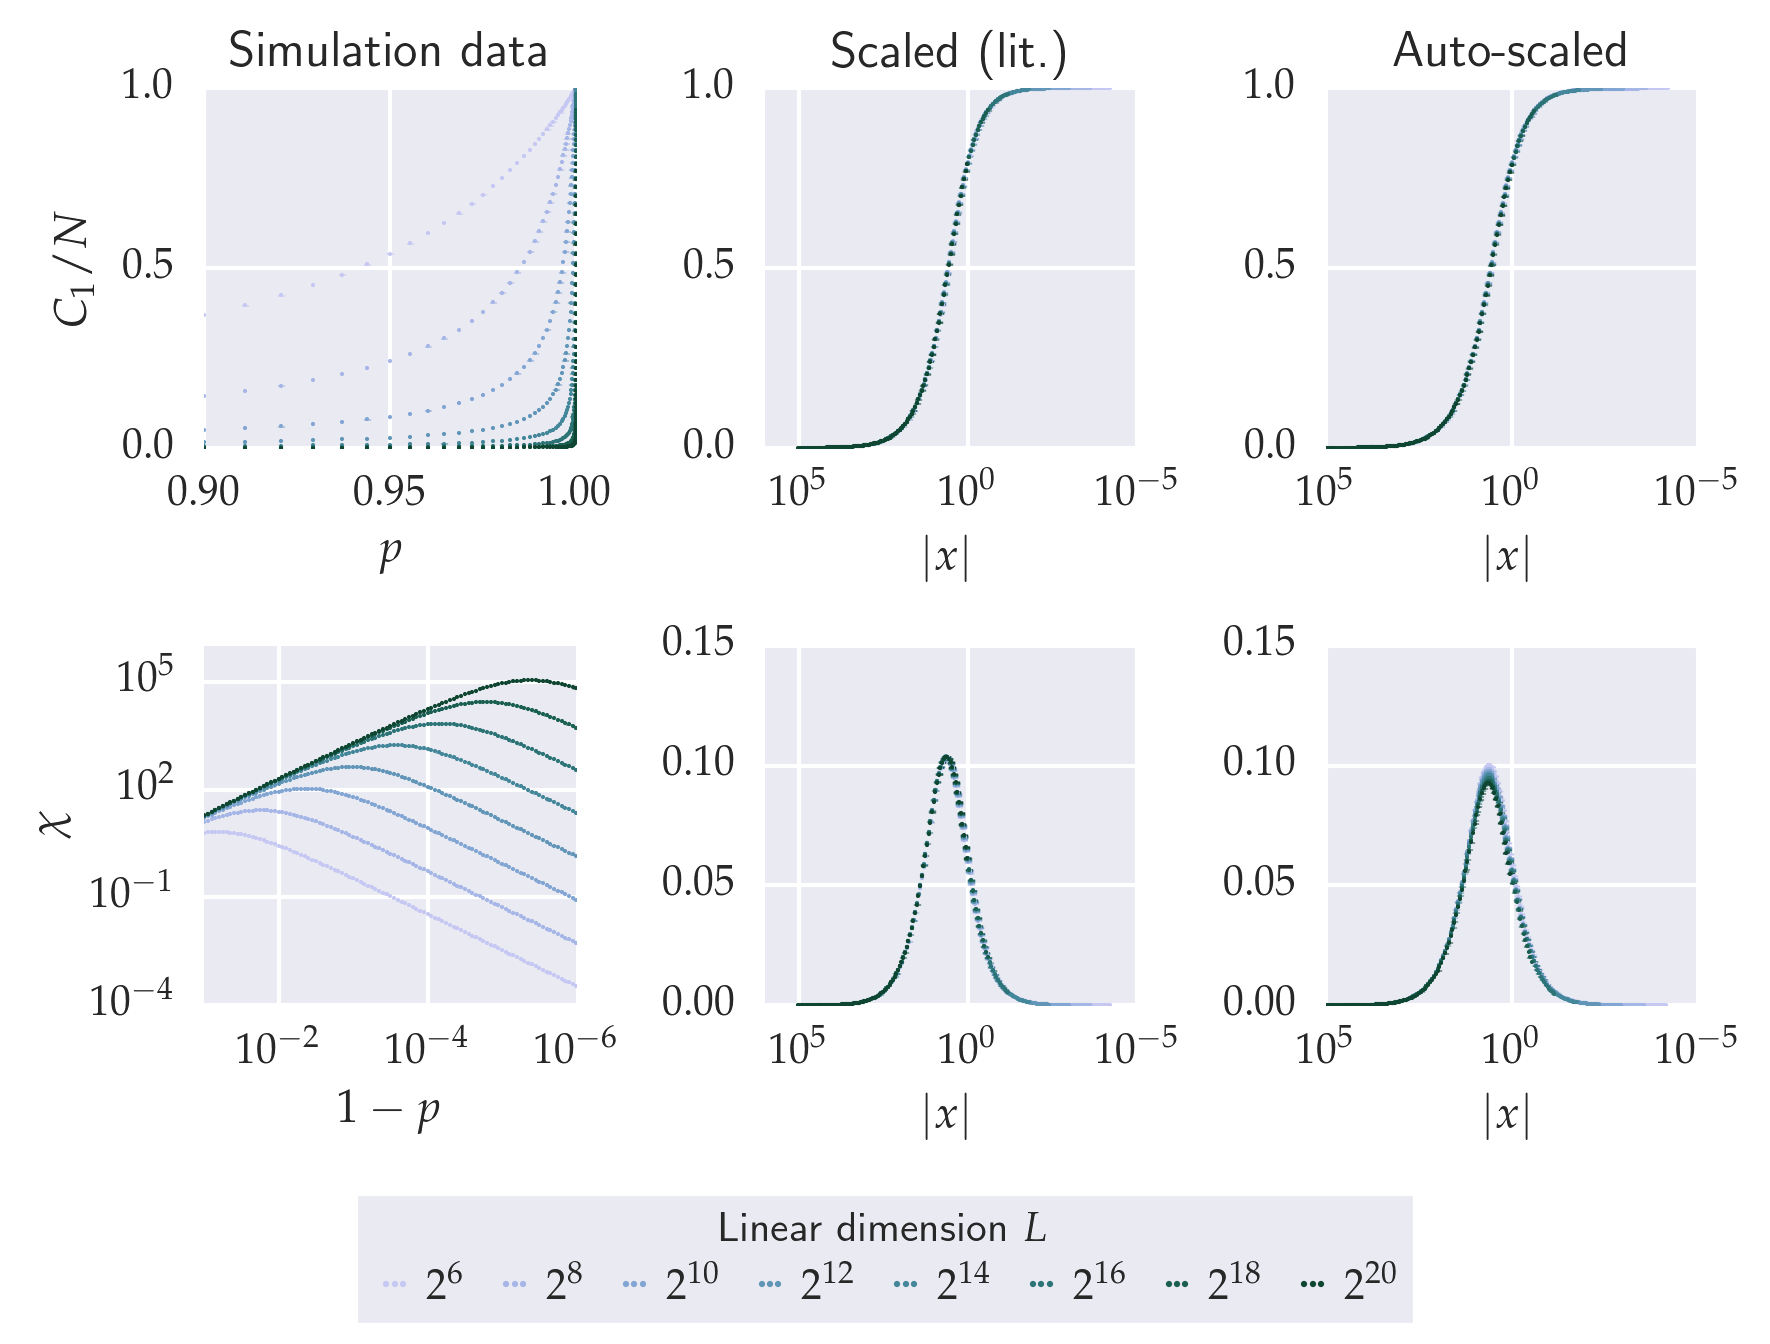

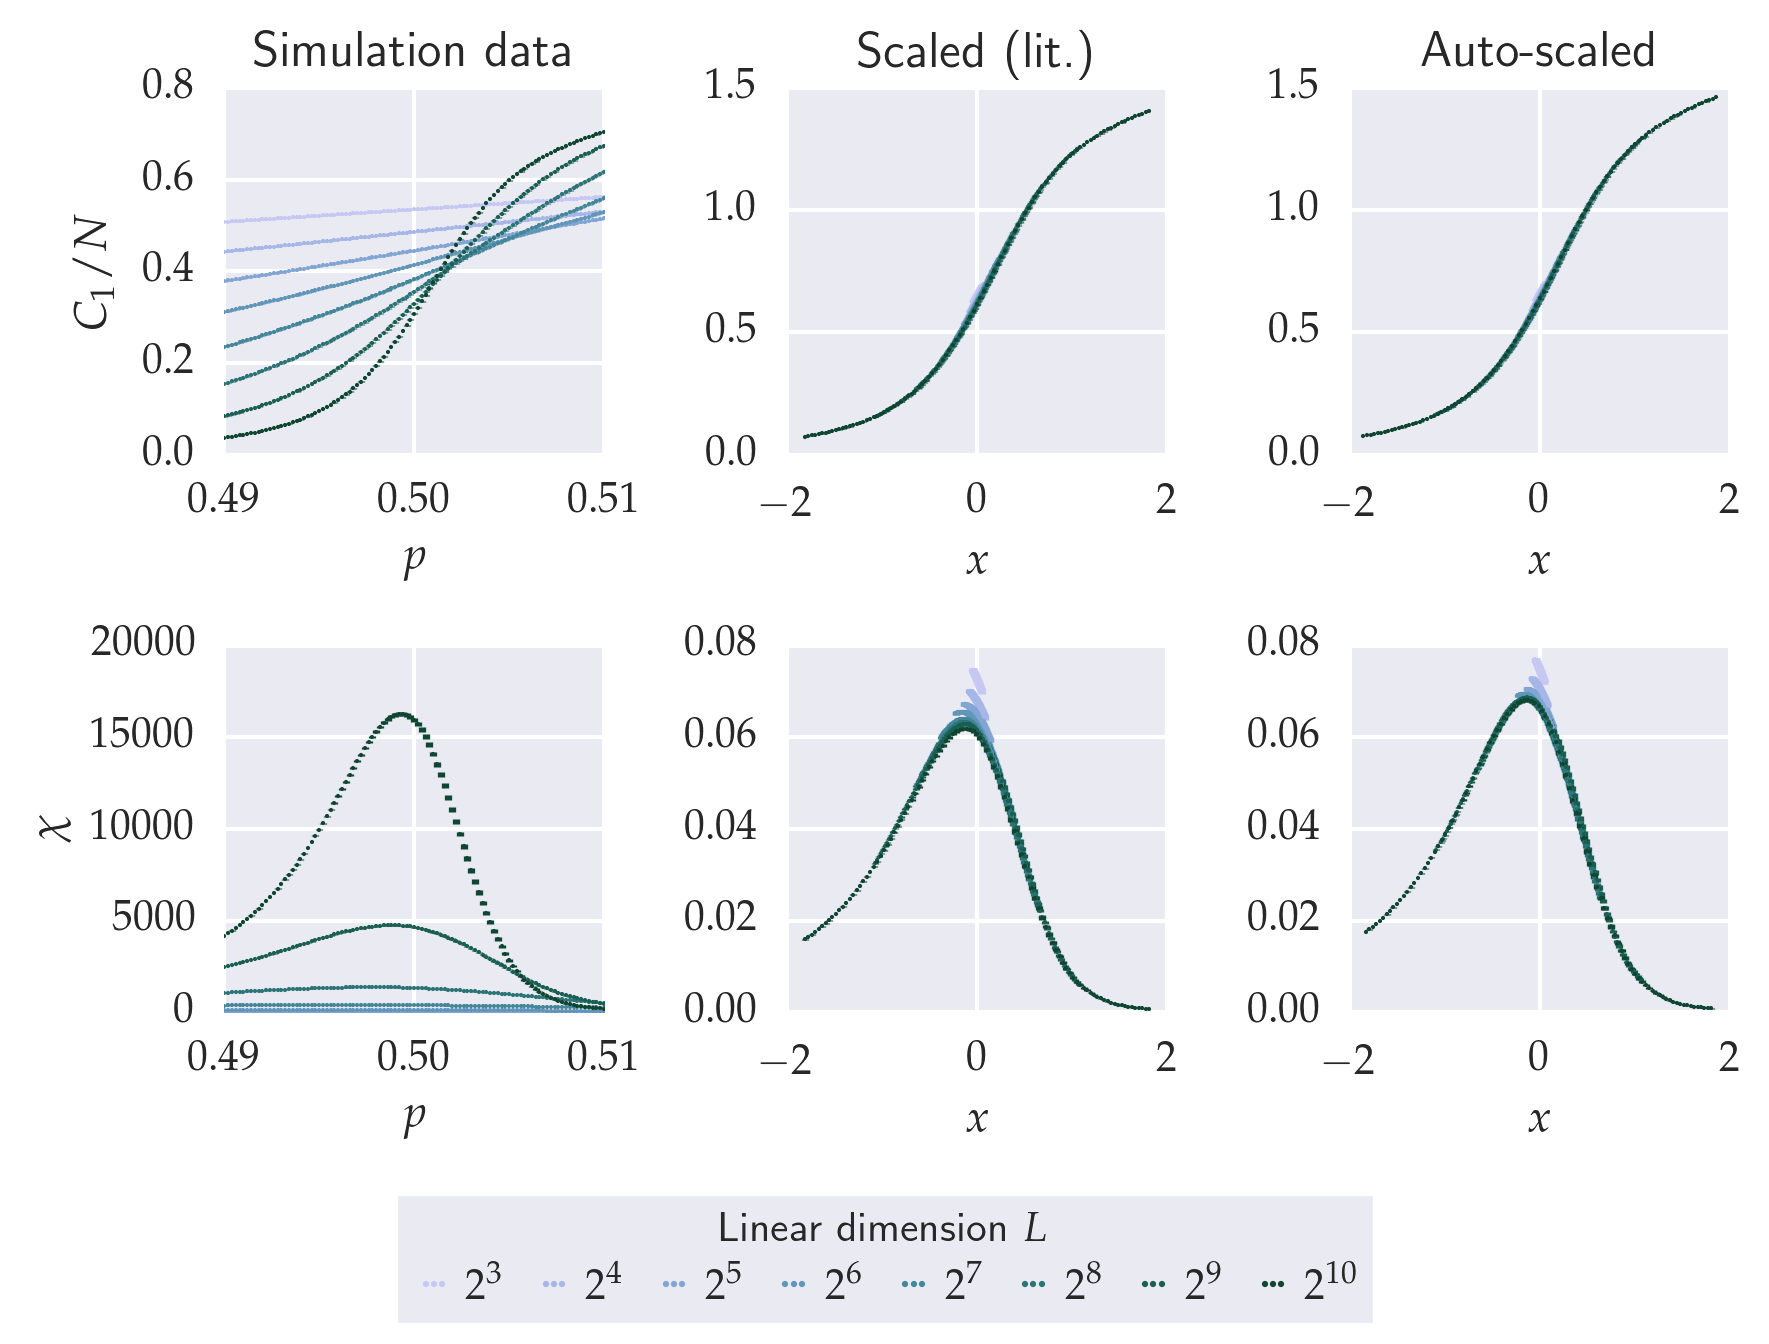

In [14]:
assert len(system_sizes['1D']) == len(system_sizes['2D'])
num_system_sizes = len(system_sizes['1D'])

assert len(config['1D']['quantities']) == len(config['2D']['quantities'])
num_quantities = len(config['1D']['quantities'])

# Define colors
palette = sns.cubehelix_palette(
    n_colors=num_system_sizes,
    start=2.0, rot=0.4, gamma=1.0, hue=1.0, light=0.8, dark=0.2,
)

plot_properties = {
    'ms': 2,
    'fmt': '.',
}

for key, my_system_sizes in system_sizes.items():  # '1D', '2D'
    fig, axes = plt.subplots(
        nrows=num_quantities, ncols=3,
        figsize=(6, 1 + 2 * num_quantities),
    )

    # plot original data
    axes[0, 0].set_title('Simulation data')
    for quantity, my_axes in zip(config[key]['quantities'], axes):
        my_config = config[key][quantity]
        
        ax = my_axes[0]
        ax.set_prop_cycle(cycler('color', palette))
        if my_config.get('log_data', False):
            ax.set_xscale('log')
            ax.set_yscale('log')
            for y, dy, size in zip(
                a[key][quantity], da[key][quantity], my_system_sizes,
            ):
                ax.errorbar(
                    1 - ps[key], y, yerr=dy, label=size,
                    **plot_properties
                )
            ax.invert_xaxis()
            ax.locator_params(axis='x', numticks=3)        
            ax.locator_params(axis='y', numticks=4)        
            ax.set_xlabel(r'$1 - p$')

        else:
            # default
            for y, dy in zip(a[key][quantity], da[key][quantity]):
                ax.errorbar(
                    ps[key], y, yerr=dy,
                    **plot_properties
                )
            ax.locator_params(axis='x', nbins=3)
            ax.locator_params(axis='y', nbins=4)
            ax.set_xlabel(r'$p$')

        try:
            ax.set_ylabel(config[quantity]['ylabel'])
        except KeyError:
            pass
        
    # plot data scaled by literature and optimized exponents
    for exp_index, (exp_key, title) in enumerate(zip(
        ['literature', 'optimized'],
        ['Scaled (lit.)', 'Auto-scaled'],
    )):
        axes[0, exp_index + 1].set_title(title)
        
        for quantity_index, quantity in enumerate(
            config[key]['quantities']
        ):
            my_config = config[key][quantity]
            my_scaled_data = scaled_data[key][quantity][exp_key]
        
            ax = axes[quantity_index, exp_index + 1]
            ax.set_prop_cycle(cycler('color', palette))
            if key == '1D':
                ax.set_xscale('log')
                for x, y, dy in zip(
                    my_scaled_data.x,
                    my_scaled_data.y,
                    my_scaled_data.dy,
                ):
                    ax.errorbar(
                        -x, y, yerr=dy, **plot_properties
                    )
                ax.invert_xaxis()
                ax.locator_params(axis='x', numticks=3)        
                ax.set_xlabel(r'$|x|$')
            else:
                # default
                for x, y, dy in zip(
                    my_scaled_data.x,
                    my_scaled_data.y,
                    my_scaled_data.dy,
                ):
                    ax.errorbar(
                        x, y, yerr=dy, **plot_properties
                    )
                ax.locator_params(axis='x', nbins=3)
                ax.set_xlabel(r'$x$')
    
            ax.locator_params(axis='y', nbins=4)
    
    import matplotlib.lines as mlines
    
    fig.legend(
        handles=[
            mlines.Line2D(
                [], [], ls=' ', marker='.', color=color, ms=3,
            )
            for color in palette
        ],
        labels=[
            r'$2^{{{:n}}}$'.format(log)
            for log in np.log2(my_system_sizes)
        ],
        numpoints=3,
        loc='lower center',
        ncol=num_system_sizes,
        columnspacing=0.75,
        handletextpad=0.25,
        title=r'Linear dimension $L$',
        frameon=True,
        handlelength=1,
    )
    plt.tight_layout(
        rect=[0, 0.1, 1, 0.9]
    )
    plt.show()

In [15]:
for data in bond_percolation_data.values():
    data.close()

## Results

In [16]:
print(all_exponents)

{'1D': {'moments': {'autoscaled': {'dnu': 4.7167237931903998e-06,
                                   'drho': 1.4479762551576001e-06,
                                   'dzeta': 0.0076361696412922571,
                                   'nu': 1.0034367452207009,
                                   'rho': 1.0000001610135159,
                                   'zeta': 1.011552722196388},
                    'literature': {'nu': 1.0, 'rho_c': 1.0, 'zeta': 1.0}},
        'percolation_strength': {'autoscaled': {'dnu': 0.0066467778306519773,
                                                'drho': 1.1767283504220902e-07,
                                                'dzeta': 0.00018273505453284011,
                                                'nu': 1.0034333511814242,
                                                'rho': 1.0000000280887937,
                                                'zeta': 0.00022191407753831049},
                                 'literature': {'nu': 1.0,
           

## Discussion

For the linear chain, *pyfssa* recovers the critical point both for the percolation strength and the susceptibility, where the analytical value $p_c = 1.0$ lies within the negligibly small error intervals of sizes $10^{-6}$ and $10^{-7}$.
The percolation strength scaling further recovers the $\nu$ scaling exponent within the small error interval of order of magnitude $10^{-3}$.
While the interval for the scaling exponent $\nu$ derived from automatically scaling the susceptibility data does not contain the literature value $1.0$, it deviates only by a small fraction of $10^{-3}$.
The intervals for both the order parameter exponent $\beta$ and the susceptibility exponent $\gamma$ do not contain the true values.
However, the algorithmically determined values for $\beta$ and $\gamma$ deviate from the true values by only a small fraction of the order of $10^{-4}$ and $10^{-2}$, respectively.

For the square lattice, the intervals for all exponents and all magnitudes contain the literature value and are rather small: $10^{-2}$ for the scaling exponents $\nu$, $\beta$ and $\gamma$; $10^{-4}$ for the critical point $p_c$.

In the light of this formidable agreement, we need to keep in mind that we initialized the auto-scaling algorithm with the literature values.
This certainly helps making the Nelder-Mead optimization results and error estimates well-defined.

## Conclusion

Both visual inspection as well as algorithmic scaling analysis of the bond percolation data reproduce well-established results from the literature with formidable agreement, particulary in the two-dimensional setting.
Even though the finite-size scaling analyst needs to take the usual care of manually (visually) approaching data collapse in order to initialize the Nelder-Mead search, we conclude the foregoing computational analysis to confirm that *pyfssa* is correctly implemented.